[![Open In Colab](./colab-badge.png)](https://colab.research.google.com/github/MooseNeuro/moose-notebooks/blob/main/More_complex_current_injection_protocol.ipynb) 

In [1]:
# Only required on colab!
# !pip install pymoose

# A more complex current injection protocol
## Author: Subhasis Ray
### Created: 2024-01-04

To probe a neuron, experimenters often conduct current-clamp experiments. But instead of keeping the injected current constant, the protocol may involve recording the membrane voltage without any current injection for some time, and then injecting current for another specified time window, and then going back to no current injection. The voltage transients when the current is stepped up or down reveal important properties of the cell, like the membrane time constant.

The `inject` field in `Compartment` is good for setting a constant current injection. However, for sophisticated current injection protocols, MOOSE has a separate class for generating pulses with specified amplitudes and timing. This is called `PulseGen`. To use this class, we first do the usual imports and container setup:

In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt

import moose


# initial setup
model = moose.Neutral('/model')
data = moose.Neutral('/data')

We create a `PulseGen` object named `pulse` under `/model`.

In [3]:
pg = moose.PulseGen('/model/pulse')

You can see the documentation for pulsegen using Python builtin `help()` function (or in ipython/jupyter run `moose.Pulsegen?`), or better, `moose.doc` function:

In [6]:
moose.doc('PulseGen')

class PulseGen

PulseGen: general purpose pulse generator. This can generate any number of pulses with specified level and duration.

Author:   Subhasis Ray 

Attributes:

Value Attributes:
-----------------
baseLevel (type: double, class: PulseGen)
  Basal level of the stimulus 

children (type: vector<Id>, class: PulseGen)
  vector of ObjIds listing all children of current object 

className (type: string, class: PulseGen)
  Class Name of object 

count (type: unsigned int, class: PulseGen)
  Number of pulses in a sequence 

destFields (type: vector<string>, class: PulseGen)
  List of all destination fields on Element, that is, fieldsthat are accessed 
  as Element functions. 

dt (type: double, class: PulseGen)
  Timestep used for this Element. Zero if not scheduled. 

fieldIndex (type: unsigned int, class: PulseGen)
  For a FieldElement: field Index of self.For a regular Element: zero. 


firstDelay (type: double, class: PulseGen)
  Delay to start of the first pulse in a sequence 


That looks like quite a lot! Much of this is, however, system level methods or attributes that you as a user need not worry about. 

`Value` attributes are fields which simply store a value. For example, in `Compartment` we saw `inject` and `Vm` fields, which stored the amplitude of the injected current and the membrane voltage respectively.`Src` attributes and `Dest` attributes are fields that are connected via messages. They are shorthand for `source` and `destination` respectively. These are intended for communication between objects during simulation.

Suppose object `A` has a src attribute `x` and another object `B` has a compatible dest attribute `y`. Then you can connect the field `x` of `A` to the field `y` of `B` using `moose.connect` function. During simulation, moose will transmit the value of `x` the field `y` of `B`. We already did this when connecting a table to a compartment. `requestOut` is the src field of `Table` that sends request for value. The corresponding dest field in `Compartment` was `getVm`. In general, for any value field `v` there is a corresponding dest field `getV` that can be used for obtaining the value of `v` at simulation run time.

The output of a `PulseGen` is stored in the value field `outputValue`, and the corresponding dest field is `getOutputValue`.

In order to see the output of the pulse generator over time we need a table to record it, and we have to connect the table's `requestOut` message field to the pulse generator's  `getOutputValue` field.

In [7]:
pout = moose.Table('/data/pout')
moose.connect(pout, 'requestOut', pg, 'getOutputValue')

<moose.SingleMsg id=5 dataIndex=0 path=/Msgs[0]/singleMsg[0]>

A `PulseGen` can produce different levels of output at specified times, for specified durations. We can start by setting the `firstDelay`, `firstWidth`, and `firstLevel` fields.

In [8]:
pg.firstDelay = 20e-3
pg.firstWidth = 10e-3
pg.firstLevel = 1e-9

In [9]:
runtime = 30e-3  # Run for 30 ms
moose.reinit()
moose.start(runtime)


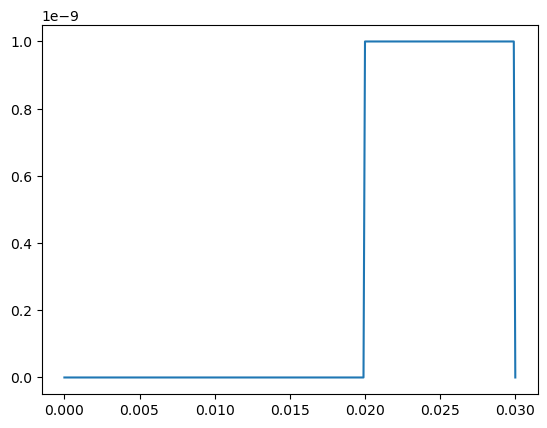

In [10]:
plt.plot(np.arange(len(pout.vector)) * pout.dt, pout.vector)

### Exercise
1. What in the plot correspond to `firstDelay`, `firstWidth`, and `firstLevel`?
1. Here we kept the runtime 30 ms, exactly the sum of `firstDelay` and `firstWidth`. What happens if we increase the time to 90 ms?
   - Ans: You should see from the plot that the `PulseGen` repeats the pulse at 20 ms delay from the end of the first pulse. In this way we can deliver a uniform series of pulses at a given rate.

## Multiple pulses with different levels, delays, and widths
In addition to a single step change, electrophysiologists may also inject into a neuron current pulses with different amplitudes. `PulseGen` actually has three lookup fields, which are like arrays, called `delay`, `width`, and `level`.

Set the `count` field to the desired number of pulses. The count is 2 by default, only for 3 or more pulse parameters you have to modify it.

In [11]:
pg.count = 3

After setting the pulse-count you have to set the delay, level, and and width for each pulse.

In [12]:
pg.delay[0] = 10e-3
pg.level[0] = 10e-6
pg.width[0] = 10e-3
pg.delay[1] = 20e-3
pg.level[1] = 20e-6
pg.width[1] = 20e-3
pg.delay[2] = 50e-3
pg.level[2] = 30e-6
pg.width[2] = 30e-3


Text(0, 0.5, 'Amplitude (mA)')

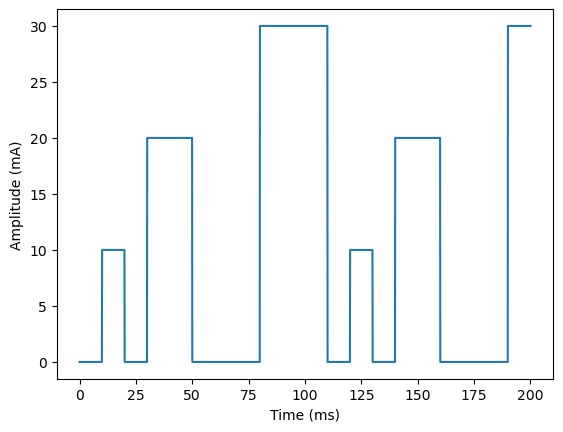

In [13]:
# Set the run time long enough to include all the pulses and their second cycle
runtime = 200e-3
moose.reinit()
moose.start(runtime)

# Plot the data
plt.plot(np.arange(len(pout.vector)) * pout.dt * 1e3, pout.vector * 1e6)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (mA)')

### Exercise
1. What do the `delay` values represent for successive pulses? What is special about `delay[0]` (also referred as `firstDelay`)?

## Create a compartment and connect the pulse generator
Now that you have learnt how to create complex patterns of pulses, create a compartment and inject current from the pulse generator.

In [14]:
# Create a compartment and connect a table to to record its Vm
comp = moose.Compartment('/model/comp')
vm_tab = moose.Table('/data/Vm')
moose.connect(vm_tab, 'requestOut', comp, 'getVm')

<moose.SingleMsg id=5 dataIndex=1 path=/Msgs[0]/singleMsg[1]>

The src attribute of `PulseGen` to send out its output is named `output`. The dest attribute on `Compartment` through which the injection current can be set at simulation runtime is called `injectMsg`. Connect these up to let the injection current be dynamically set from the pulse generator at runtime.

In [15]:
# Connect the output of the pulse generator into the compartment's `injectMsg`
moose.connect(pg, 'output', comp, 'injectMsg')

<moose.SingleMsg id=5 dataIndex=2 path=/Msgs[0]/singleMsg[2]>

In [16]:
comp.Rm = 1e4
comp.Cm = 1e-7
comp.initVm = -70e-3
comp.Vm = comp.initVm

Text(0, 0.5, 'Amplitude (mA)')

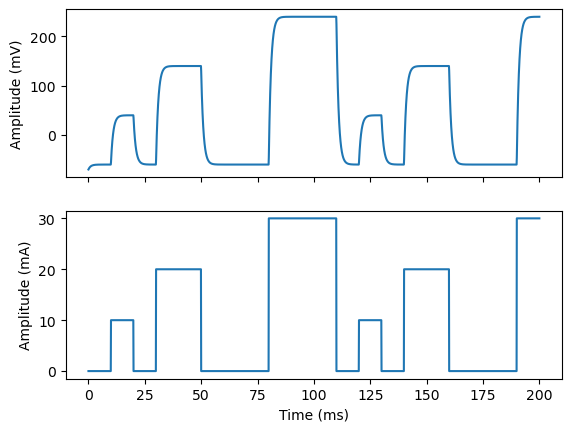

In [17]:
runtime = 200e-3
moose.reinit()
moose.start(runtime)
fig, axes = plt.subplots(nrows=2, sharex='all')
axes[0].plot(np.arange(len(vm_tab.vector)) * vm_tab.dt * 1e3, vm_tab.vector * 1e3)
axes[0].set_ylabel('Amplitude (mV)')

axes[1].plot(np.arange(len(pout.vector)) * pout.dt * 1e3, pout.vector * 1e6)
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude (mA)')


Do you notice the little transient at the beginning? That is because we did not specify the resting membrane potential $Em$, whose default value is $-60 mV$ in moose. Set it to the same value as `initVm` to get the correct simulation.

In [19]:
comp.Em = -70e-3

Text(0, 0.5, 'Amplitude (mA)')

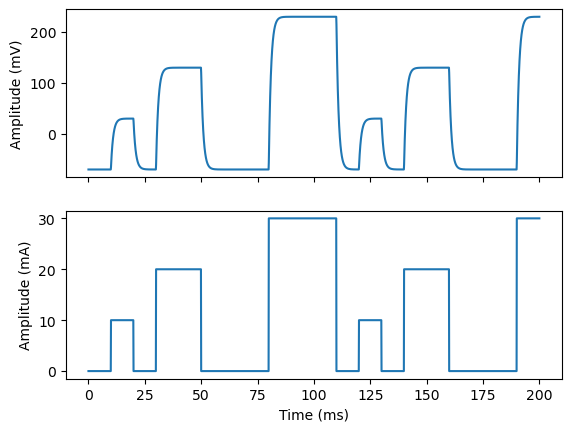

In [20]:
runtime = 200e-3
moose.reinit()
moose.start(runtime)
fig, axes = plt.subplots(nrows=2, sharex='all')
axes[0].plot(np.arange(len(vm_tab.vector)) * vm_tab.dt * 1e3, vm_tab.vector * 1e3)
axes[0].set_ylabel('Amplitude (mV)')

axes[1].plot(np.arange(len(pout.vector)) * pout.dt * 1e3, pout.vector * 1e6)
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude (mA)')


### Exercise
1. What is the difference between `initVm` and `Em`? In the first simulation of the compartment, which one was the stable value of `Vm` when zero current was injected into the compartment?